# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Load Dataset

In [2]:
df = pd.read_csv('data_files/concatted_data.csv')

df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.rename(columns={'realSum': 'ROOM_PRICE'})

In [3]:
df.head(3)

,ROOM_PRICE,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,194.033698,Private room,False,True,2,False,1,0,10,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,0
1,344.245776,Private room,False,True,4,False,0,0,8,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,0
2,264.101422,Private room,False,True,2,False,0,1,9,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ROOM_PRICE                  51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  int64  
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  int64  
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

In [5]:
# convert data type to int

df['person_capacity'] = df['person_capacity'].astype(int)

Group features

In [6]:
categorical_features = ['room_type', 'room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz', 'city', 'is_weekend']
continuous_num_features = ['guest_satisfaction_overall', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat']
ordinal_num_features = ['person_capacity', 'cleanliness_rating', 'bedrooms'] # Cleanliness rating?

## Handle Missing Values

In [7]:
missing_summary = pd.DataFrame({
    'Feature': df.columns,
    'Missing Count': df.isna().sum(),
    'Missing Percentage (%)': (df.isna().sum() / len(df)) * 100
})

# Filter only features with missing values
#missing_summary = missing_summary[missing_summary['Missing Count'] > 0]

missing_summary = missing_summary.sort_values(by='Missing Count', ascending=False).reset_index(drop=True)

# Display the summary table
missing_summary

,Feature,Missing Count,Missing Percentage (%)
0,ROOM_PRICE,0,0.0
1,dist,0,0.0
2,city,0,0.0
3,lat,0,0.0
4,lng,0,0.0
5,rest_index_norm,0,0.0
6,rest_index,0,0.0
7,attr_index_norm,0,0.0
8,attr_index,0,0.0
9,metro_dist,0,0.0


## Detect Duplicates

In [8]:
# Detect duplicate rows based on the 'features' list
duplicate_rows = df.duplicated(keep='first')

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


## Handle Outliers (numerical features)

### Detect Outliers using IQR

In [9]:
from scipy.stats import skew

num_features = continuous_num_features + ordinal_num_features

Q1 = df[num_features].quantile(0.25)
Q3 = df[num_features].quantile(0.75)
IQR = Q3 - Q1

outliers_IQR = ((df[num_features] < (Q1 - 1.5 * IQR)) | (df[num_features] > (Q3 + 1.5 * IQR)))

outliers_count_IQR = outliers_IQR.sum()

outliers_percentage = (outliers_count_IQR / df.shape[0]) * 100

skewness = df[num_features].apply(lambda x: skew(x.dropna()))

# Prepare summary statistics DataFrame
num_desc_stats = pd.DataFrame({
    # 'min': df[num_features].min(),
    # 'max': df[num_features].max(),
    # 'mean': df[num_features].mean(),
    # 'median': df[num_features].median(),
    # 'std': df[num_features].std(),
    'skewness': skewness,
    'outlier_count': outliers_count_IQR,
    'outliers (%)': outliers_percentage,
})

# Outlier group based on percentage
def classify_outlier_group(percentage):
    if percentage == 0:
        return 'No outliers'
    elif percentage < 5:
        return 'Low'
    elif percentage < 15:
        return 'Moderate'
    else:
        return 'High'

num_desc_stats['outlier_group'] = num_desc_stats['outliers (%)'].apply(classify_outlier_group)

# Sort by outlier_count
num_desc_stats = num_desc_stats.sort_values(by='outlier_count', ascending=False).reset_index()
num_desc_stats

,index,skewness,outlier_count,outliers (%),outlier_group
0,bedrooms,1.367736,15374,29.732918,High
1,metro_dist,4.060327,5051,9.768503,Moderate
2,attr_index,2.759900,2237,4.326300,Low
3,rest_index,1.694307,2166,4.188988,Low
4,guest_satisfaction_overall,-3.174816,2102,4.065214,Low
5,attr_index_norm,2.193103,1852,3.581720,Low
6,cleanliness_rating,-2.850204,1830,3.539173,Low
7,dist,1.731144,1746,3.376719,Low
8,rest_index_norm,1.097423,998,1.930106,Low
9,lng,0.033300,0,0.000000,No outliers


## Feature Transformation

### Standardization (Numerical Features)

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from feature_engine.outliers import Winsorizer

# Step 1: Winsorize features with high outliers

def winsorize_percentile(series, lower_percentile=5, upper_percentile=95):
    lower = np.percentile(series, lower_percentile)
    upper = np.percentile(series, upper_percentile)
    return np.clip(series, lower, upper)

df['bedrooms'] = winsorize_percentile(df['bedrooms'])
df['cleanliness_rating'] = winsorize_percentile(df['cleanliness_rating'])

# Step 2: Log transformation for skewed features
log_features = ['metro_dist', 'attr_index', 'rest_index', 'attr_index_norm', 'dist']
for feature in log_features:
    df[feature] = np.log1p(df[feature])

# Step 3: RobustScaler for outlier-affected features
robust_scaler = RobustScaler()
df[['bedrooms', 'metro_dist', 'dist']] = robust_scaler.fit_transform(df[['bedrooms', 'metro_dist', 'dist']])

# Step 4: StandardScaler for remaining numerical features
standard_scaler = StandardScaler()
standard_features = ['rest_index_norm', 'lng', 'lat', 'person_capacity', 'guest_satisfaction_overall']
df[standard_features] = standard_scaler.fit_transform(df[standard_features])

df.head(5)


,ROOM_PRICE,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,is_weekend
0,194.033698,Private room,False,True,-0.894595,False,1,0,10,0.041559,...,0.669280,2.775930,4.378149,1.642236,4.597681,-0.895292,-0.257191,1.285258,Amsterdam,0
1,344.245776,Private room,False,True,0.645605,False,0,0,8,-0.852751,...,-1.161979,-0.396941,6.449168,3.538673,6.731353,1.997130,-0.257767,1.276990,Amsterdam,0
2,264.101422,Private room,False,True,-0.894595,False,0,1,9,-0.629173,...,0.818246,3.602209,4.334357,1.606615,4.568371,-0.906512,-0.250106,1.274458,Amsterdam,0
3,433.529398,Private room,False,True,0.645605,False,0,1,9,-0.293807,...,-1.256424,0.056397,6.203087,3.300239,6.775404,2.144886,-0.258367,1.277430,Amsterdam,0
4,485.552926,Private room,False,True,-0.894595,True,0,0,10,0.600503,...,-1.113299,-0.209439,6.316858,3.410247,6.704789,1.911124,-0.257720,1.277135,Amsterdam,0


### Feature Encoding (categorical features)

Binary Label Encoding

`room_shared`, `room_private`, `host_is_superhost`

In [11]:
df['room_shared'] = df['room_shared'].map({False:0, True:1})
df['room_private'] = df['room_private'].map({False:0, True:1})
df['host_is_superhost'] = df['host_is_superhost'].map({False:0, True:1})

One Hot Encoding

`room_type` and `city`

In [12]:
one_hot_features = ['room_type', 'city']

one_hot_df = pd.get_dummies(
    df[one_hot_features], 
    prefix=one_hot_features,
    drop_first=True
).astype(int)

df_encoded = pd.concat(
    [df.drop(columns=one_hot_features), one_hot_df],
    axis=1
)

In [13]:
df_encoded.head(5)

,ROOM_PRICE,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,...,room_type_Shared room,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna
0,194.033698,0,1,-0.894595,0,1,0,10,0.041559,0.0,...,0,0,0,0,0,0,0,0,0,0
1,344.245776,0,1,0.645605,0,0,0,8,-0.852751,0.0,...,0,0,0,0,0,0,0,0,0,0
2,264.101422,0,1,-0.894595,0,0,1,9,-0.629173,0.0,...,0,0,0,0,0,0,0,0,0,0
3,433.529398,0,1,0.645605,0,0,1,9,-0.293807,1.0,...,0,0,0,0,0,0,0,0,0,0
4,485.552926,0,1,-0.894595,1,0,0,10,0.600503,0.0,...,0,0,0,0,0,0,0,0,0,0


### Feature Scaling (numerical features)

Train/Test split (avoiding data leakage)

In [22]:
X.columns

Index(['room_shared', 'room_private', 'person_capacity', 'host_is_superhost',
       'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm',
       'rest_index', 'rest_index_norm', 'lng', 'lat', 'is_weekend',
       'room_type_Private room', 'room_type_Shared room', 'city_Athens',
       'city_Barcelona', 'city_Berlin', 'city_Budapest', 'city_Lisbon',
       'city_London', 'city_Paris', 'city_Rome', 'city_Vienna'],
      dtype='object')

In [14]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=['ROOM_PRICE'], axis=1)
y = df_encoded['ROOM_PRICE']  

# drop attr_index_norm and rest_index_norm
X = X.drop(columns=['attr_index_norm', 'rest_index_norm'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Using Min-Max scaling

In [21]:
num_features.remove('attr_index_norm')
num_features.remove('rest_index_norm')

print(num_features)

['guest_satisfaction_overall', 'dist', 'metro_dist', 'attr_index', 'rest_index', 'lng', 'lat', 'person_capacity', 'cleanliness_rating', 'bedrooms']


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# X_train = scaler.fit_transform(X_train[num_features])

# X_test = scaler.transform(X_test[num_features])

X_train[X.columns] = pd.DataFrame(scaler.fit_transform(X_train[X.columns]), columns=X.columns, index=X_train.index)
X_test[X.columns] = pd.DataFrame(scaler.transform(X_test[X.columns]), columns=X.columns, index=X_test.index)


c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\fizuf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

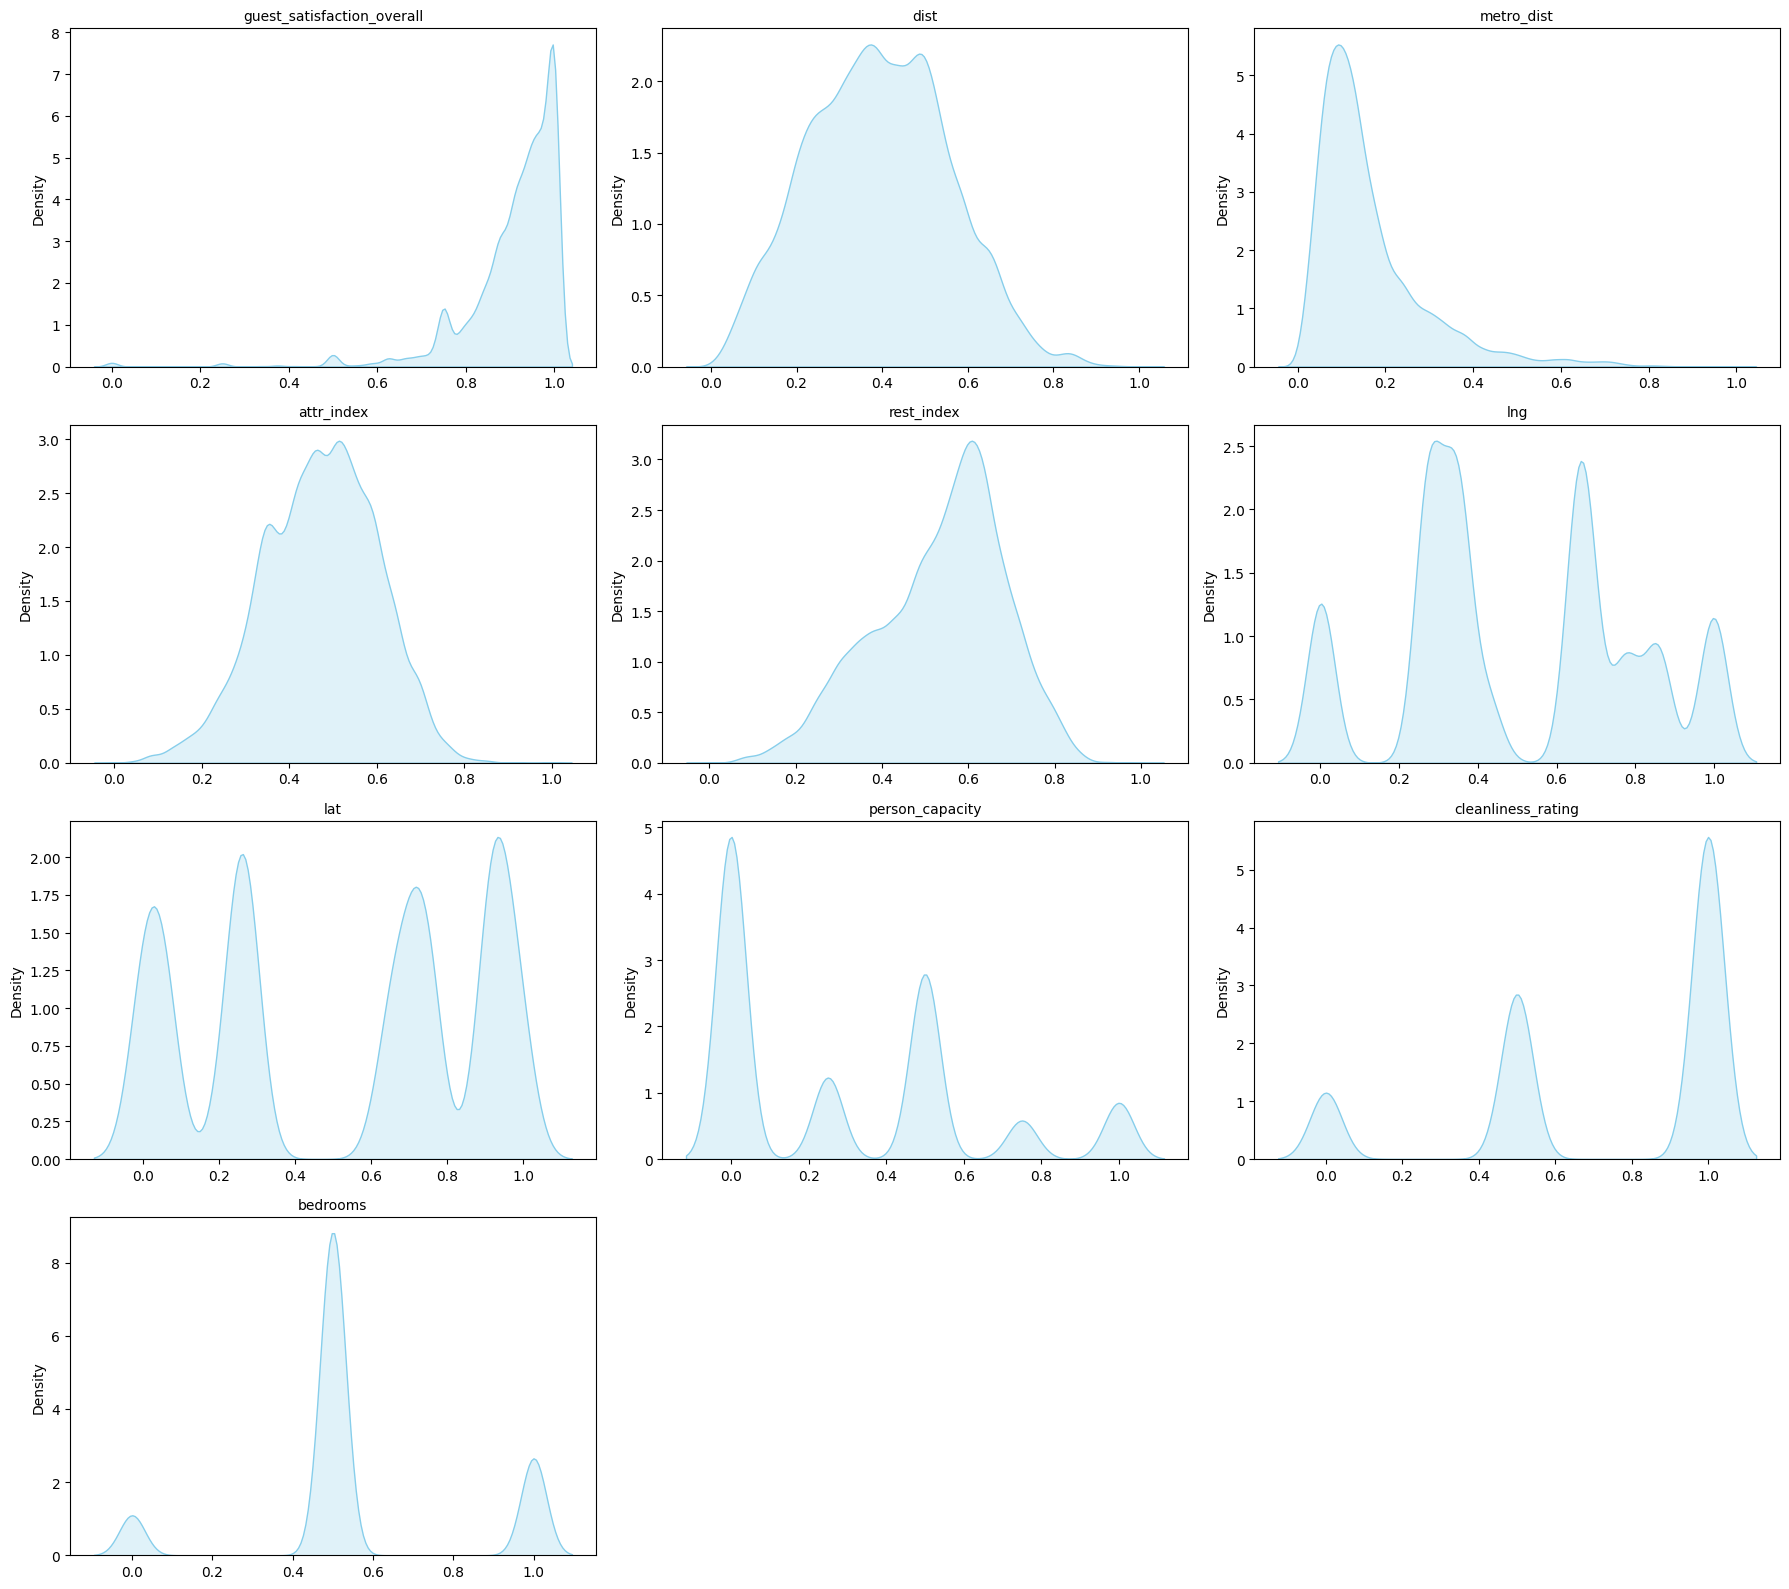

In [22]:
num_plots = min(len(num_features), 12)  
rows, cols = 4, 3

fig, axes = plt.subplots(rows, cols, figsize=(18, 16))

axes = axes.flatten()

for i, col in enumerate(num_features[:num_plots]):
    sns.kdeplot(X_train[col], ax=axes[i], fill=True, color='skyblue')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Save Datasets

In [23]:
# X_train_df = pd.DataFrame(X_train)
# y_train_df = pd.DataFrame(y_train)

# X_test_df = pd.DataFrame(X_test)
# y_test_df = pd.DataFrame(y_test)

X_train.to_csv('data_files/preprocessed_X_train.csv', index=False)
y_train.to_csv('data_files/y_train.csv', index=False)

X_test.to_csv('data_files/preprocessed_X_test.csv', index=False)
y_test.to_csv('data_files/y_test.csv', index=False)